In [4]:
# Import garbage(Shiny garbage)
from torchvision.models import resnet50, ResNet50_Weights
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resModel = resnet50(weights=ResNet50_Weights.DEFAULT)

In [5]:


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [6]:
# Use folder names to get classes list.
imageClasses = os.listdir("./Images")

In [7]:
# Process all images to be sized at 224 x 224 x 3
transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [8]:
dataset = ImageFolder("./Images", transform = transformations)
print(dataset)
print(dataset.classes[3])
print(dataset[1000])

Dataset ImageFolder
    Number of datapoints: 15520
    Root location: ./Images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
bakery
(tensor([[[0.3686, 0.3804, 0.3961,  ..., 0.5843, 0.5725, 0.5725],
         [0.3725, 0.3804, 0.4039,  ..., 0.5765, 0.5843, 0.5804],
         [0.3922, 0.3961, 0.4000,  ..., 0.5961, 0.5882, 0.5961],
         ...,
         [0.2824, 0.2667, 0.2157,  ..., 0.4000, 0.4078, 0.4196],
         [0.2118, 0.1804, 0.1137,  ..., 0.3804, 0.3804, 0.3843],
         [0.1176, 0.1020, 0.0941,  ..., 0.3529, 0.3608, 0.3608]],

        [[0.3529, 0.3608, 0.3608,  ..., 0.5882, 0.5804, 0.5765],
         [0.3569, 0.3490, 0.3686,  ..., 0.5804, 0.5843, 0.5765],
         [0.3569, 0.3608, 0.3686,  ..., 0.6000, 0.5882, 0.6000],
         ...,
         [0.2275, 0.2118, 0.1843,  ..., 0.2824, 0.2863, 0.2784],
         [0.1725, 0.1490, 0.0980,  ..., 0.2667, 0.2549, 0

In [9]:
def showImage(img, index):
  print("Class: ", dataset.classes[index], " Class Number: " + str(index))
  plt.imshow(img.permute(1, 2, 0))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
class ResNet(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = resnet50(weights=ResNet50_Weights.DEFAULT)
    endLayer = self.network.fc.in_features
    self.network.fc = nn.Linear(endLayer, len(dataset.classes))
  def forward(self, xb):
    return torch.sigmoid(self.network(xb))

model = ResNet()

Class:  warehouse  Class Number: 65


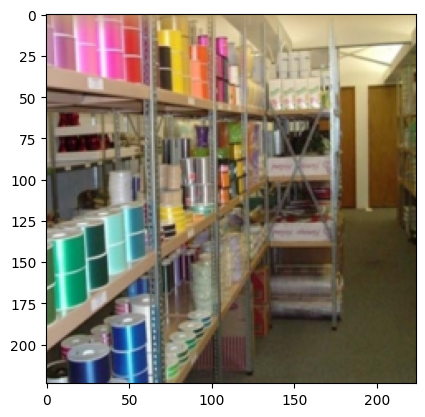

In [11]:
img, index = dataset[15000]
type(img)
showImage(img, index)

In [12]:
seed = 16
torch.manual_seed(seed)
batch_size = 15

In [13]:
train_set, val_set = random_split(dataset, [13968, 1552])
print(len(train_set))
print(len(val_set))
testData = ImageFolder("./targets", transform = transformations)
print(len(testData))

13968
1552
100


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [27]:
train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(testData, batch_size, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_set, batch_size, num_workers = 4, pin_memory = True)

In [28]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
model = to_device(model, device)

In [31]:
evaluate(model, val_dl)

{'val_loss': 4.203445911407471, 'val_acc': 0.010897437110543251}

In [32]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 6e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 3.6938, val_loss: 3.4377, val_acc: 0.6268
Epoch 2: train_loss: 3.4096, val_loss: 3.3761, val_acc: 0.6845
Epoch 3: train_loss: 3.3401, val_loss: 3.3571, val_acc: 0.7268
Epoch 4: train_loss: 3.3096, val_loss: 3.3538, val_acc: 0.7358
Epoch 5: train_loss: 3.2920, val_loss: 3.3518, val_acc: 0.7435
Epoch 6: train_loss: 3.2791, val_loss: 3.3485, val_acc: 0.7538
Epoch 7: train_loss: 3.2699, val_loss: 3.3524, val_acc: 0.7608
Epoch 8: train_loss: 3.2656, val_loss: 3.3496, val_acc: 0.7647
Epoch 9: train_loss: 3.2581, val_loss: 3.3612, val_acc: 0.7525
Epoch 10: train_loss: 3.2565, val_loss: 3.3618, val_acc: 0.7627


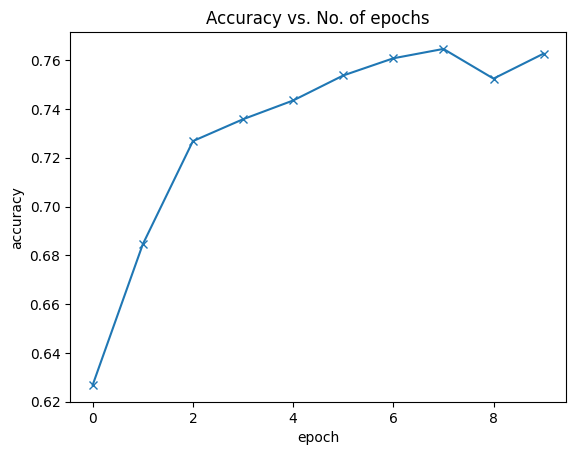

In [33]:


def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)



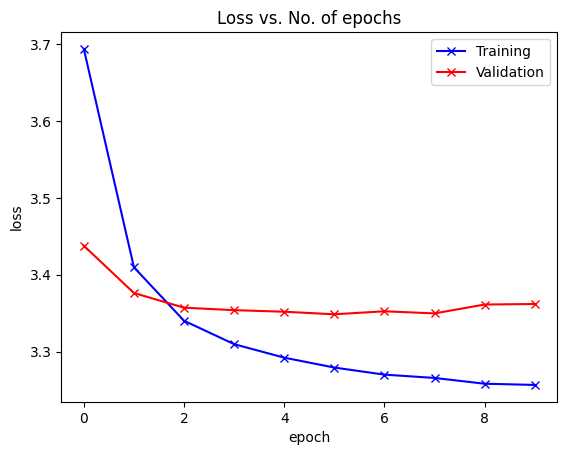

In [34]:


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)



In [55]:
from PIL import Image
from pathlib import Path

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

def predict_external_image(img):
    return predict_image(img, model)

In [56]:
preds = []
for img, index in testData:
    preds.append(predict_external_image(img))
print(preds.count('grocerystore')/len(preds))

0.59


# Resnet 50 with a super basic transfer learning process yields 59% accuracy